In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')

In [2]:

df = pd.read_csv("HR.csv")

print("Initial DataFrame:")
print(df.head())
print("\nData Types Before Conversion:")
print(df.dtypes)

Initial DataFrame:
   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years  sales  \
0                   3              0     1                      0  sales   
1                   6              0     1                      0  sales   
2                   4              0     1                      0  sales   
3                   5              0     1                      0  sales   
4                   3              0     1                      0  sales   

   salary  
0     low  
1  medium  
2  medi

In [3]:
continuous_features = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]

df[features_to_convert] = df[features_to_convert].astype('category')
print("\nData Types After Conversion:")
print(df.dtypes)

print("\nUnique Values in Categorical Features:")
for feature in features_to_convert:
    print(f"\nUnique values in '{feature}':", df[feature].unique())


Data Types After Conversion:
satisfaction_level        float64
last_evaluation           float64
number_project              int64
average_montly_hours        int64
time_spend_company          int64
Work_accident            category
left                     category
promotion_last_5years    category
sales                    category
salary                   category
dtype: object

Unique Values in Categorical Features:

Unique values in 'Work_accident': [0, 1]
Categories (2, int64): [0, 1]

Unique values in 'left': [1, 0]
Categories (2, int64): [0, 1]

Unique values in 'promotion_last_5years': [0, 1]
Categories (2, int64): [0, 1]

Unique values in 'sales': ['sales', 'accounting', 'hr', 'technical', 'support', 'management', 'IT', 'product_mng', 'marketing', 'RandD']
Categories (10, object): ['IT', 'RandD', 'accounting', 'hr', ..., 'product_mng', 'sales', 'support', 'technical']

Unique values in 'salary': ['low', 'medium', 'high']
Categories (3, object): ['high', 'low', 'medium']



Missing values in each column:
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64


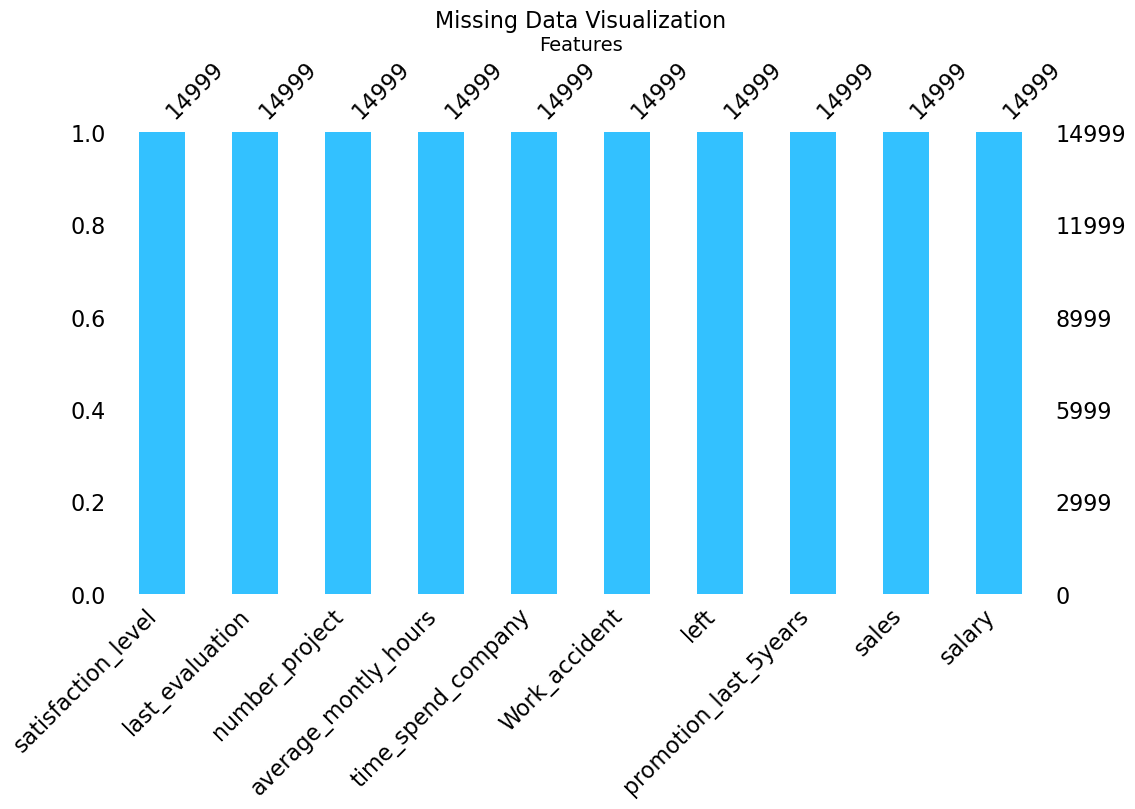

In [4]:
print("\nMissing values in each column:")
print(df.isnull().sum())

plt.figure(figsize=(12, 6))
msno.bar(df, color='#33C1FF', figsize=(12, 6))
plt.title('Missing Data Visualization', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Non-null Count', fontsize=14)
plt.show()

df.dropna(inplace=True)

In [5]:
df_encoded = pd.get_dummies(df, columns=['sales'], drop_first=True)

le = LabelEncoder()
df_encoded['salary'] = le.fit_transform(df_encoded['salary'])

print("Encoded DataFrame head:")
print(df_encoded.head())

Encoded DataFrame head:
   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company Work_accident left promotion_last_5years  salary  \
0                   3             0    1                     0       1   
1                   6             0    1                     0       2   
2                   4             0    1                     0       2   
3                   5             0    1                     0       1   
4                   3             0    1                     0       1   

   sales_RandD  sales_accounting  sales_hr  sales_

In [6]:
#Features and Target Variable
X = df_encoded.drop('left', axis=1)  
y = df_encoded['left']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0, stratify=y)
print(f'Training set shape: {X_train.shape}, Test set shape: {X_test.shape}')


Training set shape: (11999, 17), Test set shape: (3000, 17)


In [7]:
def tune_regressor_hyperparameters(reg, param_grid, X_train, y_train, scoring='neg_mean_squared_error', n_splits=3):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    reg_grid = GridSearchCV(reg, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    reg_grid.fit(X_train, y_train)
    return reg_grid.best_estimator_, reg_grid.best_params_

In [8]:
#XGBoost Model
xgb_base = xgb.XGBRegressor(objective='reg:squarederror')

xgb_param_grid = {
    'max_depth': [4, 5],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [200, 250, 300],
    'min_child_weight': [2, 3, 4]
}

best_xgb, best_xgb_hyperparameters = tune_regressor_hyperparameters(xgb_base, xgb_param_grid, X_train, y_train)
print('XGBoost Regressor Optimal Hyperparameters: \n', best_xgb_hyperparameters)


def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        "MAE": mean_absolute_error(y_test, y_test_pred),
        "MSE": mean_squared_error(y_test, y_test_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "R2 Score": r2_score(y_test, y_test_pred)
    }
    
    print(f"{model_name} Testing Data Metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
        
    return metrics


best_xgb.fit(X_train, y_train)
xgb_result = evaluate_model(best_xgb, X_train, y_train, X_test, y_test, 'XGBoost')

XGBoost Regressor Optimal Hyperparameters: 
 {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 300}
XGBoost Testing Data Metrics:
MAE: 0.0436
MSE: 0.0126
RMSE: 0.1123
R2 Score: 0.9305


In [12]:
#CatBoost Model
catboost_base = CatBoostRegressor()  # Removed silent=True

catboost_param_grid = {
    'depth': [4, 5],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'iterations': [200, 250, 300],
    'l2_leaf_reg': [2, 3, 4]
}

print("Tuning CatBoost Hyperparameters...")
best_catboost, best_catboost_hyperparameters = tune_regressor_hyperparameters(catboost_base, catboost_param_grid, X_train, y_train)
print('CatBoost Regressor Optimal Hyperparameters: \n', best_catboost_hyperparameters)

print("Fitting CatBoost model...")
best_catboost.fit(X_train, y_train)
print("Evaluating CatBoost model...")
catboost_result = evaluate_model(best_catboost, X_train, y_train, X_test, y_test, 'CatBoost')

# Random Forest Model
rf_base = RandomForestRegressor(random_state=0)

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 5, 6],
    'min_samples_split': [2, 5],
}

print("Tuning Random Forest Hyperparameters...")
best_rf, best_rf_hyperparameters = tune_regressor_hyperparameters(rf_base, rf_param_grid, X_train, y_train)
print('Random Forest Regressor Optimal Hyperparameters: \n', best_rf_hyperparameters)

print("Fitting Random Forest model...")
best_rf.fit(X_train, y_train)
print("Evaluating Random Forest model...")
rf_result = evaluate_model(best_rf, X_train, y_train, X_test, y_test, 'Random Forest')

Tuning CatBoost Hyperparameters...
0:	learn: 0.3397016	total: 3.6ms	remaining: 1.08s
1:	learn: 0.2801638	total: 8.44ms	remaining: 1.26s
2:	learn: 0.2496095	total: 12.1ms	remaining: 1.2s
3:	learn: 0.2234081	total: 15.2ms	remaining: 1.13s
4:	learn: 0.2100530	total: 19ms	remaining: 1.12s
5:	learn: 0.1991510	total: 23.3ms	remaining: 1.14s
6:	learn: 0.1922394	total: 29.2ms	remaining: 1.22s
7:	learn: 0.1871863	total: 33.1ms	remaining: 1.21s
8:	learn: 0.1787499	total: 36.6ms	remaining: 1.18s
9:	learn: 0.1755924	total: 40.8ms	remaining: 1.18s
10:	learn: 0.1732689	total: 44.8ms	remaining: 1.18s
11:	learn: 0.1711882	total: 48.5ms	remaining: 1.16s
12:	learn: 0.1669220	total: 52.2ms	remaining: 1.15s
13:	learn: 0.1656378	total: 56.4ms	remaining: 1.15s
14:	learn: 0.1640527	total: 60.5ms	remaining: 1.15s
15:	learn: 0.1618466	total: 64.1ms	remaining: 1.14s
16:	learn: 0.1608030	total: 67.2ms	remaining: 1.12s
17:	learn: 0.1595349	total: 70.6ms	remaining: 1.11s
18:	learn: 0.1584092	total: 74ms	remaining:

196:	learn: 0.1060061	total: 584ms	remaining: 305ms
197:	learn: 0.1058382	total: 589ms	remaining: 303ms
198:	learn: 0.1056752	total: 595ms	remaining: 302ms
199:	learn: 0.1055977	total: 599ms	remaining: 299ms
200:	learn: 0.1054872	total: 603ms	remaining: 297ms
201:	learn: 0.1052712	total: 608ms	remaining: 295ms
202:	learn: 0.1051674	total: 613ms	remaining: 293ms
203:	learn: 0.1050212	total: 619ms	remaining: 291ms
204:	learn: 0.1049377	total: 624ms	remaining: 289ms
205:	learn: 0.1048398	total: 654ms	remaining: 298ms
206:	learn: 0.1047821	total: 659ms	remaining: 296ms
207:	learn: 0.1045631	total: 667ms	remaining: 295ms
208:	learn: 0.1044233	total: 672ms	remaining: 293ms
209:	learn: 0.1043815	total: 676ms	remaining: 290ms
210:	learn: 0.1042455	total: 680ms	remaining: 287ms
211:	learn: 0.1040390	total: 687ms	remaining: 285ms
212:	learn: 0.1038240	total: 692ms	remaining: 283ms
213:	learn: 0.1037268	total: 696ms	remaining: 280ms
214:	learn: 0.1036492	total: 701ms	remaining: 277ms
215:	learn: 

53:	learn: 0.1382458	total: 197ms	remaining: 899ms
54:	learn: 0.1376480	total: 201ms	remaining: 896ms
55:	learn: 0.1371998	total: 204ms	remaining: 888ms
56:	learn: 0.1367434	total: 206ms	remaining: 879ms
57:	learn: 0.1364425	total: 209ms	remaining: 872ms
58:	learn: 0.1362319	total: 213ms	remaining: 870ms
59:	learn: 0.1359412	total: 216ms	remaining: 863ms
60:	learn: 0.1354538	total: 219ms	remaining: 856ms
61:	learn: 0.1347796	total: 221ms	remaining: 850ms
62:	learn: 0.1341189	total: 224ms	remaining: 843ms
63:	learn: 0.1338255	total: 227ms	remaining: 838ms
64:	learn: 0.1334893	total: 231ms	remaining: 833ms
65:	learn: 0.1332074	total: 233ms	remaining: 826ms
66:	learn: 0.1331248	total: 235ms	remaining: 818ms
67:	learn: 0.1328444	total: 238ms	remaining: 812ms
68:	learn: 0.1326380	total: 240ms	remaining: 804ms
69:	learn: 0.1319826	total: 244ms	remaining: 801ms
70:	learn: 0.1316502	total: 247ms	remaining: 797ms
71:	learn: 0.1312575	total: 250ms	remaining: 791ms
72:	learn: 0.1310543	total: 252

248:	learn: 0.0997754	total: 776ms	remaining: 159ms
249:	learn: 0.0996902	total: 780ms	remaining: 156ms
250:	learn: 0.0996229	total: 784ms	remaining: 153ms
251:	learn: 0.0994299	total: 787ms	remaining: 150ms
252:	learn: 0.0992891	total: 790ms	remaining: 147ms
253:	learn: 0.0992181	total: 794ms	remaining: 144ms
254:	learn: 0.0990575	total: 797ms	remaining: 141ms
255:	learn: 0.0990309	total: 800ms	remaining: 137ms
256:	learn: 0.0988458	total: 803ms	remaining: 134ms
257:	learn: 0.0987317	total: 807ms	remaining: 131ms
258:	learn: 0.0986393	total: 812ms	remaining: 128ms
259:	learn: 0.0985470	total: 817ms	remaining: 126ms
260:	learn: 0.0984027	total: 822ms	remaining: 123ms
261:	learn: 0.0983151	total: 827ms	remaining: 120ms
262:	learn: 0.0982154	total: 832ms	remaining: 117ms
263:	learn: 0.0981635	total: 835ms	remaining: 114ms
264:	learn: 0.0980280	total: 838ms	remaining: 111ms
265:	learn: 0.0979739	total: 841ms	remaining: 108ms
266:	learn: 0.0978923	total: 844ms	remaining: 104ms
267:	learn: 

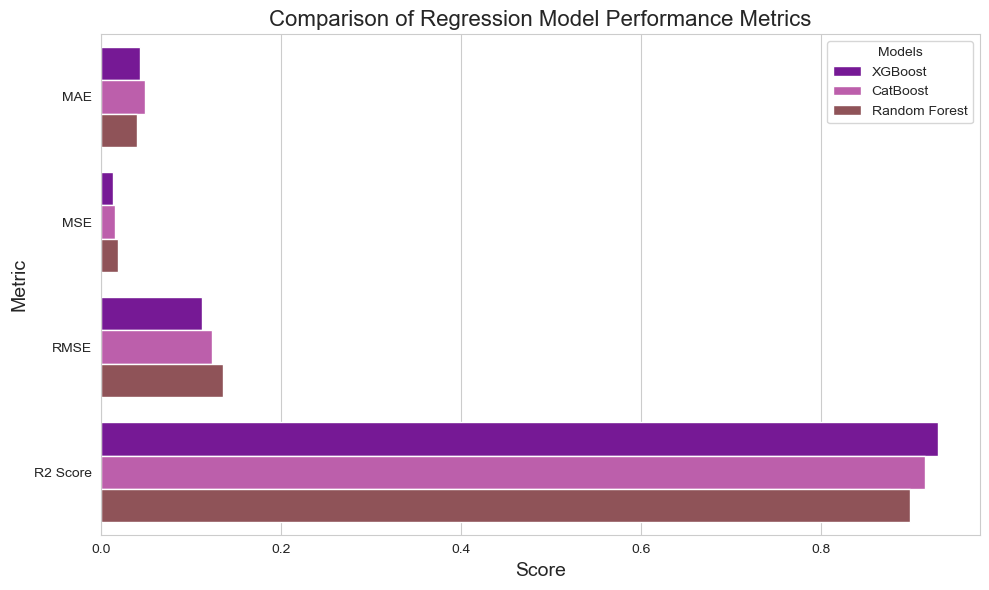

In [13]:
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'CatBoost', 'Random Forest'],
    'MAE': [xgb_result['MAE'], catboost_result['MAE'], rf_result['MAE']],
    'MSE': [xgb_result['MSE'], catboost_result['MSE'], rf_result['MSE']],
    'RMSE': [xgb_result['RMSE'], catboost_result['RMSE'], rf_result['RMSE']],
    'R2 Score': [xgb_result['R2 Score'], catboost_result['R2 Score'], rf_result['R2 Score']]
})

melted_metrics_df = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

unique_models = melted_metrics_df['Model'].unique()
random_colors = [np.random.rand(3,) for _ in unique_models]
palette = dict(zip(unique_models, random_colors))

sns.barplot(x='Score', y='Metric', hue='Model', data=melted_metrics_df, palette=palette)
plt.title('Comparison of Regression Model Performance Metrics', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Metric', fontsize=14)
plt.legend(title='Models')
plt.tight_layout()
plt.show()

In [16]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_train_pred)

    mae_test = mean_absolute_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_test_pred)

    metrics_df = pd.DataFrame(data={
        'MAE': [mae_test],
        'MSE': [mse_test],
        'RMSE': [rmse_test],
        'R2 Score': [r2_test]
    }, index=[model_name])
    
    print(f"{model_name} Training Data Metrics:")
    print("MAE: {:.4f}".format(mae_train))
    print("MSE: {:.4f}".format(mse_train))
    print("RMSE: {:.4f}".format(rmse_train))
    print("R2 Score: {:.4f}".format(r2_train))

    print(f"\n{model_name} Testing Data Metrics:")
    print("MAE: {:.4f}".format(mae_test))
    print("MSE: {:.4f}".format(mse_test))
    print("RMSE: {:.4f}".format(rmse_test))
    print("R2 Score: {:.4f}".format(r2_test))
        
    return metrics_df

In [17]:
xgb_result = evaluate_model(best_xgb, X_train, y_train, X_test, y_test, 'XGBoost')
catboost_result = evaluate_model(best_catboost, X_train, y_train, X_test, y_test, 'CatBoost')
rf_result = evaluate_model(best_rf, X_train, y_train, X_test, y_test, 'Random Forest')

metrics_data = {
    'Model': ['XGBoost', 'CatBoost', 'Random Forest'],
    'MAE': [xgb_result['MAE'].values[0], catboost_result['MAE'].values[0], rf_result['MAE'].values[0]],
    'MSE': [xgb_result['MSE'].values[0], catboost_result['MSE'].values[0], rf_result['MSE'].values[0]],
    'RMSE': [xgb_result['RMSE'].values[0], catboost_result['RMSE'].values[0], rf_result['RMSE'].values[0]],
    'R2 Score': [xgb_result['R2 Score'].values[0], catboost_result['R2 Score'].values[0], rf_result['R2 Score'].values[0]],
}
evaluation_metrics_df = pd.DataFrame(metrics_data)
evaluation_metrics_df

XGBoost Training Data Metrics:
MAE: 0.0253
MSE: 0.0040
RMSE: 0.0633
R2 Score: 0.9779

XGBoost Testing Data Metrics:
MAE: 0.0436
MSE: 0.0126
RMSE: 0.1123
R2 Score: 0.9305
CatBoost Training Data Metrics:
MAE: 0.0380
MSE: 0.0090
RMSE: 0.0950
R2 Score: 0.9503

CatBoost Testing Data Metrics:
MAE: 0.0490
MSE: 0.0153
RMSE: 0.1235
R2 Score: 0.9159
Random Forest Training Data Metrics:
MAE: 0.0396
MSE: 0.0181
RMSE: 0.1344
R2 Score: 0.9005

Random Forest Testing Data Metrics:
MAE: 0.0397
MSE: 0.0182
RMSE: 0.1349
R2 Score: 0.8997


,Model,MAE,MSE,RMSE,R2 Score
0,XGBoost,0.043599,0.012610,0.112295,0.930467
1,CatBoost,0.049016,0.015256,0.123514,0.915879
2,Random Forest,0.039664,0.018196,0.134894,0.899665


In [ ]:
# In conclusion,XGBoost outperformed the other models with the lowest MAE (0.0436) and the highest R² Score (0.9305)

# making it the best choice for accurate predictions.

# CatBoost also showed strong performance, especially with categorical data.

# while Random Forest had the lowest MSE but struggled with larger prediction errors. 

# Overall, for this dataset, XGBoost is recommended for its balance of accuracy and reliability.